In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [89]:
!pip uninstall xgboost -y
!pip install -U xgboost==1.5.1

!pip uninstall scikit-learn -y
!pip install -U scikit-learn

Found existing installation: xgboost 1.5.0
Uninstalling xgboost-1.5.0:
  Successfully uninstalled xgboost-1.5.0
ERROR: Could not find a version that satisfies the requirement xgboost==1.5.1 (from versions: 0.4a12, 0.4a13, 0.4a14, 0.4a15, 0.4a18, 0.4a19, 0.4a20, 0.4a21, 0.4a22, 0.4a23, 0.4a24, 0.4a25, 0.4a26, 0.4a27, 0.4a28, 0.4a29, 0.4a30, 0.6a1, 0.6a2, 0.7.post3, 0.7.post4, 0.71, 0.72.1, 0.80, 0.81, 0.82, 0.90, 1.0.0rc1, 1.0.0rc2, 1.0.0, 1.0.1, 1.0.2, 1.1.0rc1, 1.1.0rc2, 1.1.0, 1.1.1, 1.2.0rc1, 1.2.0rc2, 1.2.0, 1.2.1rc1, 1.2.1, 1.3.0rc1, 1.3.0.post0, 1.3.1, 1.3.2, 1.3.3, 1.4.0rc1, 1.4.0, 1.4.1, 1.4.2, 1.5.0rc1, 1.5.0)
ERROR: No matching distribution found for xgboost==1.5.1
Found existing installation: scikit-learn 1.0.1
Uninstalling scikit-learn-1.0.1:
  Successfully uninstalled scikit-learn-1.0.1
  Using cached scikit_learn-1.0.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (23.2 MB)


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import matplotlib.gridspec as gridspec
import seaborn as sns

from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import brier_score_loss
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
import warnings
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
import xgboost as xgb
import joblib
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
import os

In [6]:
basedir = '/content/drive/MyDrive/recidivism/'
raw_datadir = os.path.join(basedir,'data','01_raw')
interim_datadir = os.path.join(basedir,'data','02_interim')
processed_datadir = os.path.join(basedir,'data','03_processed')
modelsdir = os.path.join(basedir,'models/onehot')

In [7]:
xtrain_path = os.path.join(processed_datadir, "Xtrain.csv")
xtest_path = os.path.join(processed_datadir, "Xtest.csv")
ytrain_path = os.path.join(processed_datadir, "ytrain.csv")
ytest_path = os.path.join(processed_datadir, "ytest.csv")

X_train = pd.read_csv(xtrain_path)
X_test = pd.read_csv(xtest_path)
y_train = pd.read_csv(ytrain_path, squeeze=True)
y_test = pd.read_csv(ytest_path, squeeze=True)

print("X_train:",X_train.shape)
print("X_test:",X_test.shape)
print("y_train:",y_train.shape)
print("y_test:",y_test.shape)

X_train: (19920, 42)
X_test: (4980, 42)
y_train: (19920,)
y_test: (4980,)


In [8]:
columns = ['Age_at_Release',
'Education_Level',
'Dependents',
'Prison_Years',
'Prior_Arrest_Episodes_Felony',
'Prior_Arrest_Episodes_Misd',
'Prior_Arrest_Episodes_Violent',
'Prior_Arrest_Episodes_Property',
'Prior_Arrest_Episodes_Drug',
'Prior_Arrest_Episodes_PPViolationCharges',
'Prior_Conviction_Episodes_Felony',
'Prior_Conviction_Episodes_Misd',
'Prior_Conviction_Episodes_Prop',
'Prior_Conviction_Episodes_Drug',
'Delinquency_Reports',
'Program_Attendances',
'Program_UnexcusedAbsences',
'Residence_Changes',
'Drug_Test_Results',
'Percent_Days_Employed']
result = pd.Series({c: X_train[columns][c].unique() for c in X_train[columns]})
print(result)

Age_at_Release                              [28-32, 38-42, 43-47, 33-37, 23-27, 48 or olde...
Education_Level                             [Less than HS diploma, At least some college, ...
Dependents                                                               [2, 3 or more, 1, 0]
Prison_Years                                [More than 3 years, Less than 1 year, 1-2 year...
Prior_Arrest_Episodes_Felony                       [6, 2, 5, 4, 10 or more, 3, 9, 1, 7, 8, 0]
Prior_Arrest_Episodes_Misd                                      [3, 6 or more, 1, 0, 4, 2, 5]
Prior_Arrest_Episodes_Violent                                            [1, 0, 2, 3 or more]
Prior_Arrest_Episodes_Property                                     [1, 2, 3, 0, 5 or more, 4]
Prior_Arrest_Episodes_Drug                                         [4, 1, 2, 0, 3, 5 or more]
Prior_Arrest_Episodes_PPViolationCharges                           [3, 5 or more, 1, 0, 2, 4]
Prior_Conviction_Episodes_Felony                            

In [9]:
class GroupImputer(BaseEstimator, TransformerMixin):
    '''
    Class used for imputing missing values in a pd.DataFrame using either mean or median of a group.
    
    Parameters
    ----------    
    group_cols : list
        List of columns used for calculating the aggregated value 
    target : str
        The name of the column to impute
    metric : str
        The metric to be used for remplacement, can be one of ['mean', 'median']

    Returns
    -------
    X : array-like
        The array with imputed values in the target column
    '''
    def __init__(self, group_cols, target, metric='mean'):
        
        assert metric in ['mean', 'median'], 'Unrecognized value for metric, should be mean/median'
        assert type(group_cols) == list, 'group_cols should be a list of columns'
        assert type(target) == str, 'target should be a string'
        
        self.group_cols = group_cols
        self.target = target
        self.metric = metric
    
    def fit(self, X, y=None):
        
        assert pd.isnull(X[self.group_cols]).any(axis=None) == False, 'There are missing values in group_cols'
        
        impute_map = X.groupby(self.group_cols)[self.target].agg(self.metric) \
                                                            .reset_index(drop=False)
        
        self.impute_map_ = impute_map
        
        return self 
    
    def transform(self, X, y=None):
        
        # make sure that the imputer was fitted
        check_is_fitted(self, 'impute_map_')
        
        X = X.copy()
        
        for index, row in self.impute_map_.iterrows():
            ind = (X[self.group_cols] == row[self.group_cols]).all(axis=1)
            X.loc[ind, self.target] = X.loc[ind, self.target].fillna(row[self.target])
        
        return X.values



## Create imputers
* imputer Avg_Days_per_DrugTest based upon column mean

In [10]:

simpleImputer = SimpleImputer()

## Create Encoders

### One Hot Encoder

In [11]:
oneHot = OneHotEncoder(drop='if_binary')



### Ordinal Encoder

#### Define order for categories and create encoder

In [12]:
ageList = ['18-22','23-27','28-32','33-37','38-42','43-47','48 or older']
education = ['Less than HS diploma','High School Diploma', 'At least some college']
dependents = ['0', '1', '2', '3 or more']
prisonYears = ['Less than 1 year', '1-2 years', 'Greater than 2 to 3 years','More than 3 years']
felony = ['0', '1', '2', '3', '4','5', '6', '7', '8', '9', '10 or more']
misd = ['0','1','2','3','4','5','6 or more']
violent = ['0','1','2', '3 or more']
prop = ['0','1','2','3','4','5 or more']
drug = ['0','1','2','3','4','5 or more']
ppviolation = ['0','1','2','3','4','5 or more']
felony2 = ['0', '1', '2', '3 or more']
misd2 = ['0','1', '2', '3', '4 or more']
prop2 = ['0', '1', '2', '3 or more']
drug2 = ['0','1', '2 or more']
delinquency = ['0' ,'1', '2','3', '4 or more']
attendances = ['0','1','2','3','4','5', '6','7','8','9', '10 or more']
unexcused = ['0', '1', '2', '3 or more']
residence = ['0','1','2', '3 or more']
employment = ['None', 'Less Than Half', 'More Than Half', 'All']
 
ordinalEnc = OrdinalEncoder(categories=[ageList,education,dependents,
                                        prisonYears,felony,misd,violent,prop,drug,
                                        ppviolation,felony2,misd2,prop2,drug2,
                                        delinquency,attendances,unexcused,
                                        residence,employment])

In [13]:
ordlist = ['Age_at_Release','Education_Level',
'Dependents','Prison_Years','Prior_Arrest_Episodes_Felony',
'Prior_Arrest_Episodes_Misd','Prior_Arrest_Episodes_Violent',
'Prior_Arrest_Episodes_Property','Prior_Arrest_Episodes_Drug',
'Prior_Arrest_Episodes_PPViolationCharges','Prior_Conviction_Episodes_Felony',
'Prior_Conviction_Episodes_Misd','Prior_Conviction_Episodes_Prop',
'Prior_Conviction_Episodes_Drug','Delinquency_Reports',
'Program_Attendances','Program_UnexcusedAbsences',
'Residence_Changes','Percent_Days_Employed']

onehotlist = ['Age_at_Release','Education_Level',
'Dependents','Prison_Years','Prior_Arrest_Episodes_Felony',
'Prior_Arrest_Episodes_Misd','Prior_Arrest_Episodes_Violent',
'Prior_Arrest_Episodes_Property','Prior_Arrest_Episodes_Drug',
'Prior_Arrest_Episodes_PPViolationCharges','Prior_Conviction_Episodes_Felony',
'Prior_Conviction_Episodes_Misd','Prior_Conviction_Episodes_Prop',
'Prior_Conviction_Episodes_Drug','Delinquency_Reports',
'Program_Attendances','Program_UnexcusedAbsences',
'Residence_Changes','Percent_Days_Employed',
'Gender','Race','Residence_PUMA','Gang_Affiliated',
'Supervision_Level_First','Prison_Offense','Prior_Arrest_Episodes_DVCharges',
'Prior_Arrest_Episodes_GunCharges','Prior_Conviction_Episodes_Viol',
'Prior_Conviction_Episodes_PPViolationCharges','Prior_Conviction_Episodes_DomesticViolenceCharges',
'Prior_Conviction_Episodes_GunCharges','Prior_Revocations_Parole',
'Prior_Revocations_Probation','Condition_MH_SA','Condition_Cog_Ed',
'Condition_Other','Violations_Instruction',
'Violations_FailToReport','Violations_MoveWithoutPermission',
'Employment_Exempt','Drug_Test_Results']

scalerlist = ['Supervision_Risk_Score_First']

## Define Standard Scaler

In [14]:
scaler = StandardScaler()

## Define Column Transformer for use in models

In [15]:


ct = ColumnTransformer([
                       ('oneHot',oneHot,onehotlist),
                        ('scaler', scaler, ['Supervision_Risk_Score_First'])
                        ], 
                       remainder='passthrough')

ct2 = ColumnTransformer([
                        ('scaler', scaler, ['Supervision_Risk_Score_First'])
                        ], 
                       remainder='passthrough')

# Model Building

## Define function to calculate scores and produce ROC curve
## Define common variables for use in all models

In [16]:
def calc_scores(model,X_test,y_test,estimator_name):
    proba = model.predict_proba(X_test)
    preds = model.predict(X_test)
    pos_proba = proba[:,1]
    bs = brier_score_loss(y_test, pos_proba)
    f1 = f1_score(y_test,preds)
    rs = recall_score(y_test,preds)
    ps = precision_score(y_test,preds)
    roc = roc_auc_score(y_test, preds)
    fpr, tpr, thresholds = roc_curve(y_test,preds)
    # display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc,estimator_name=estimator_name)
    display = RocCurveDisplay.from_predictions(preds,y_test,name=estimator_name)
    scores = [bs, f1, rs, ps, roc]
    return scores, display

tests = ['Brier Score', 'F1 Score', 'Recall', 'Precision', 'ROC_AUC']
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=3)
cv = StratifiedKFold(n_splits=10)

## Initialize PCA and define parameters for grid search


In [17]:
pca = PCA()
pca_params = {'pca__n_components':['mle', .2, .4, .6, .8], 'pca__svd_solver': ['full']}

## K-Nearest Neighbors

In [23]:
knn_model = KNeighborsClassifier()
knn_model_pca = KNeighborsClassifier()
knn_pipeline = Pipeline([("columnTransformer",ct),("knn", knn_model)])
knn_pipeline_pca = Pipeline([("columnTransformer",ct),('pca', pca),("knn", knn_model_pca)])

In [24]:
knn_params = {'knn__n_neighbors':[5,10,15,20], 'knn__metric':['minkowski']}
knn_params_pca = {**knn_params, **pca_params}

In [25]:
knn_cv = GridSearchCV(knn_pipeline, knn_params, scoring='neg_brier_score', n_jobs=-1, cv=cv)

In [28]:
knn_cv.fit(X_train,y_train)
joblib.dump(knn_cv.best_estimator_, os.path.join(modelsdir,"model_knn.pkl"))

['/content/drive/MyDrive/recidivism/models/onehot/model_knn.pkl']

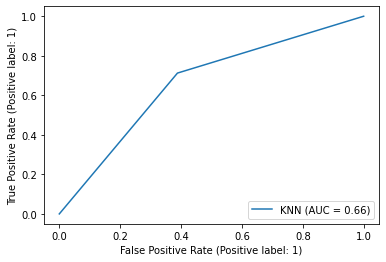

In [29]:
knn_scores, knn_display = calc_scores(knn_cv, X_test, y_test, 'KNN')

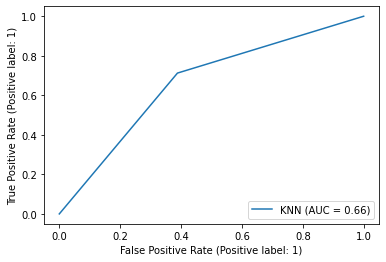

In [30]:
knn_scores, knn_display = calc_scores(knn_cv, X_test, y_test, 'KNN')


In [31]:
print(pd.DataFrame(knn_scores, index=tests, columns=['KNN']))


                  KNN
Brier Score  0.208799
F1 Score     0.727151
Recall       0.742466
Precision    0.712455
ROC_AUC      0.658854


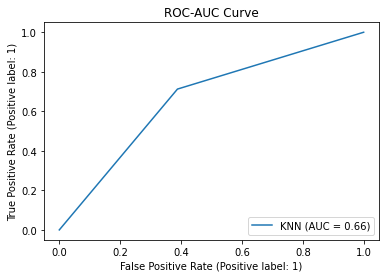

In [32]:
fig, ax = plt.subplots()
knn_display.plot(ax=ax)
ax.set_title("ROC-AUC Curve")
plt.show()

## Logistic Regression with Elastic Net Regularization

In [35]:
lr_model = LogisticRegression()

lr_params = {'lr__warm_start': [True, False],'lr__penalty':['elasticnet'],'lr__C':[0.01, 0.05, 0.1, 0.15,0.25, 0.5, 1.0],'lr__solver':['saga'], 'lr__max_iter':[5000], 'lr__l1_ratio':np.linspace(0,1,20,True)}

lr_pipeline = Pipeline([("columnTransformer",ct),("lr", lr_model)])


In [36]:
lr_cv = GridSearchCV(lr_pipeline, lr_params, scoring='neg_brier_score', n_jobs=-1,cv=cv)
lr_cv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('columnTransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('oneHot',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['Age_at_Release',
                                                                          'Education_Level',
                                                                          'Dependents',
                                                                          'Prison_Years',
                                                                          'Prior_Arrest_Episodes_Felony',
                                                                          'Prior_Arrest_Episodes_Misd',
              

In [37]:
joblib.dump(lr_cv.best_estimator_, os.path.join(modelsdir,'model_lr.pkl'))

['/content/drive/MyDrive/recidivism/models/onehot/model_lr.pkl']

NameError: ignored

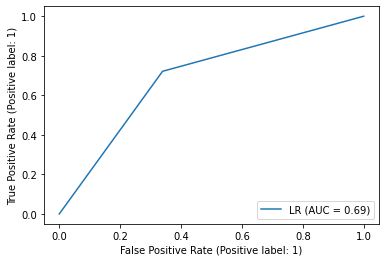

In [39]:
lr_scores, lr_display = calc_scores(lr_cv, X_test, y_test, 'LR')

In [40]:
pd.DataFrame(lr_scores, index=tests, columns=['Logistic Regression'])

,Logistic Regression
Brier Score,0.192270
F1 Score,0.756598
Recall,0.795205
Precision,0.721566
ROC_AUC,0.680127


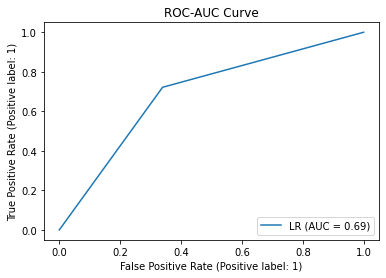

In [41]:
fig, ax = plt.subplots()
lr_display.plot(ax=ax)
ax.set_title("ROC-AUC Curve")
plt.show()

In [42]:
lr_cv.best_params_

{'lr__C': 0.15,
 'lr__l1_ratio': 0.894736842105263,
 'lr__max_iter': 5000,
 'lr__penalty': 'elasticnet',
 'lr__solver': 'saga',
 'lr__warm_start': True}

In [43]:
lr_cv.best_estimator_['lr'].coef_

array([[ 0.9209822 ,  0.56102851,  0.17355825,  0.        , -0.13835065,
        -0.34131642, -0.6151322 ,  0.        ,  0.1589948 ,  0.        ,
        -0.02505399,  0.00822052,  0.        ,  0.00272671,  0.01428735,
        -0.19553345,  0.27465022, -0.06764421,  0.28665679, -0.47235005,
         0.33492991, -0.19667127, -0.09844691,  0.        , -0.04111499,
         0.02007984, -0.07719338,  0.11364928,  0.13151913, -0.10986601,
        -0.0648245 , -0.02328217,  0.        ,  0.07523466,  0.        ,
         0.1690795 , -0.03882376, -0.02988026,  0.03832754,  0.03880045,
        -0.07172908, -0.00557111,  0.        ,  0.        ,  0.07971285,
         0.14218766, -0.01197308, -0.01353639,  0.04774628,  0.12909957,
         0.        , -0.03470846, -0.25781092, -0.09384603,  0.        ,
         0.00722624,  0.07151116,  0.25648021, -0.07171452, -0.02035281,
         0.03182632,  0.06857919, -0.18493464, -0.0025641 ,  0.        ,
         0.02819756,  0.14880715,  0.        ,  0. 

## Decision Tree

In [44]:
dt_model = DecisionTreeClassifier()
dt_params = {'dt__criterion':['gini', 'entropy'], 'dt__splitter':['best', 'random']}
dt_pipeline = Pipeline([('columnTransformer', ct),('dt', dt_model)])



In [45]:
dt_cv = GridSearchCV(dt_pipeline, dt_params, scoring='neg_brier_score', n_jobs=-1, cv=cv)
dt_cv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('columnTransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('oneHot',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['Age_at_Release',
                                                                          'Education_Level',
                                                                          'Dependents',
                                                                          'Prison_Years',
                                                                          'Prior_Arrest_Episodes_Felony',
                                                                          'Prior_Arrest_Episodes_Misd',
              

In [46]:
joblib.dump(dt_cv.best_estimator_, os.path.join(modelsdir,'model_dt.pkl'))

['/content/drive/MyDrive/recidivism/models/onehot/model_dt.pkl']

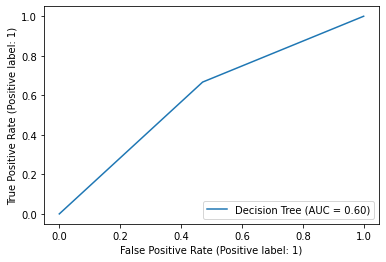

In [47]:
dt_scores, dt_display = calc_scores(dt_cv, X_test, y_test, 'Decision Tree')

In [48]:
pd.DataFrame(dt_scores, index=tests, columns=['Decision Tree'])

,Decision Tree
Brier Score,0.389759
F1 Score,0.668262
Recall,0.669521
Precision,0.667008
ROC_AUC,0.597867


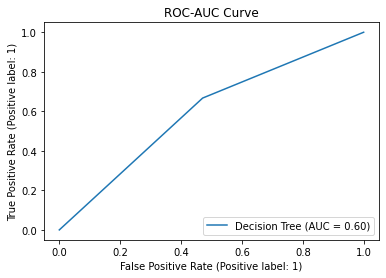

In [49]:
fig, ax = plt.subplots()
dt_display.plot(ax=ax)
ax.set_title("ROC-AUC Curve")
plt.show()

## Random Forest

In [50]:
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_params = {'rf__criterion':['gini', 'entropy'], 'rf__max_depth':[5,10,15,25,50]}
rf_pipeline = Pipeline([('columnTransformer', ct),('rf', rf_model)])



In [51]:
rf_cv = GridSearchCV(rf_pipeline, rf_params, scoring='neg_brier_score', cv=cv)
rf_cv.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('columnTransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('oneHot',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['Age_at_Release',
                                                                          'Education_Level',
                                                                          'Dependents',
                                                                          'Prison_Years',
                                                                          'Prior_Arrest_Episodes_Felony',
                                                                          'Prior_Arrest_Episodes_Misd',
              

In [52]:
joblib.dump(rf_cv.best_estimator_, os.path.join(modelsdir,"model_rf.pkl"))

['/content/drive/MyDrive/recidivism/models/onehot/model_rf.pkl']

,Random Forest
Brier Score,0.196186
F1 Score,0.764484
Recall,0.831507
Precision,0.707459
ROC_AUC,0.672064


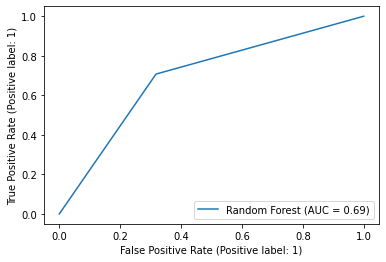

In [53]:
rf_scores, rf_display = calc_scores(rf_cv, X_test, y_test, 'Random Forest')
pd.DataFrame(rf_scores, index=tests, columns=['Random Forest'])

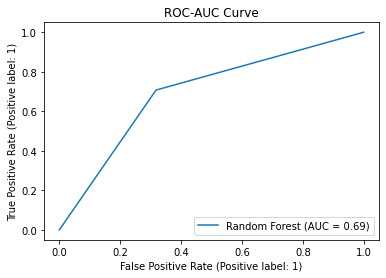

In [54]:
fig, ax = plt.subplots()
rf_display.plot(ax=ax)
ax.set_title("ROC-AUC Curve")
plt.show()

In [55]:
rf_cv.best_estimator_

Pipeline(steps=[('columnTransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('oneHot',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['Age_at_Release',
                                                   'Education_Level',
                                                   'Dependents', 'Prison_Years',
                                                   'Prior_Arrest_Episodes_Felony',
                                                   'Prior_Arrest_Episodes_Misd',
                                                   'Prior_Arrest_Episodes_Violent',
                                                   'Prior_Arrest_Episodes_Property',
                                                   'Prior_Arrest_Episodes_Dru...
                                                   'Prior_Arrest_Episodes_DVCharges',
                                       

## SGD Classifier

In [56]:
sgd_model = SGDClassifier(random_state=42)
sgd_params = {'sgd__loss':['modified_huber','log'], 'sgd__penalty':['elasticnet'], 
              'sgd__alpha':[0.0001,0.001, 0.01, 0.1, 1,10,100], 'sgd__l1_ratio':np.linspace(0,1,10,True)}
sgd_pipeline = Pipeline([('columnTransformer', ct),('sgd', sgd_model)])



In [57]:
sgd_cv = GridSearchCV(sgd_pipeline, sgd_params, scoring='neg_brier_score', cv=cv)
sgd_cv.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('columnTransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('oneHot',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['Age_at_Release',
                                                                          'Education_Level',
                                                                          'Dependents',
                                                                          'Prison_Years',
                                                                          'Prior_Arrest_Episodes_Felony',
                                                                          'Prior_Arrest_Episodes_Misd',
              

In [58]:
joblib.dump(sgd_cv.best_estimator_, os.path.join(modelsdir,'model_sgd.pkl'))

['/content/drive/MyDrive/recidivism/models/onehot/model_sgd.pkl']

,SGD
Brier Score,0.192802
F1 Score,0.766924
Recall,0.832192
Precision,0.711150
ROC_AUC,0.676533


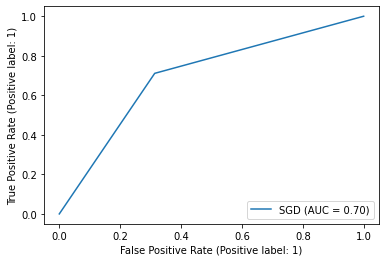

In [59]:
sgd_scores, sgd_display = calc_scores(sgd_cv, X_test, y_test, 'SGD')
pd.DataFrame(sgd_scores, index=tests, columns=['SGD'])

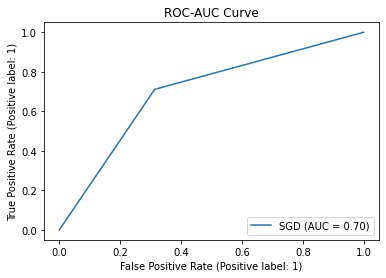

In [60]:
fig, ax = plt.subplots()
sgd_display.plot(ax=ax)
ax.set_title("ROC-AUC Curve")
plt.show()

In [61]:
sgd_cv.best_params_

{'sgd__alpha': 0.001,
 'sgd__l1_ratio': 0.3333333333333333,
 'sgd__loss': 'log',
 'sgd__penalty': 'elasticnet'}

## XGBoost Model


In [108]:
xgb_params_old = {
    'xgb__booster': ['gbtree'],
    'xgb__eta': [.0001, .0005, .001, .005, .01, .1], 
    'xgb__max_depth': [3, 6, 8],  
    'xgb__objective': ['binary:logistic'],  
    'xgb__num_class': [2],
    'xgb__subsample': [0.5, 0.75],
    'xgb__tree_method': ['auto', 'hist'],
    'xgb__eval_metric':['auc'], 
    'xgb__min_child_weight': [1, 5],
    'xgb__max_delta_step': [1, 5],
    'xgb__random_state': [42]} 

xgb_params = {
    'xgb__n_estimators':[1000],
    'xgb__booster': ['gbtree'],
    'xgb__eta': [.0001, .0005, .001, .005, .01, .1], 
    'xgb__max_depth': [3, 6, 8],  
    'xgb__objective': ['binary:logistic'],  
    'xgb__subsample': [0.5, 0.75],
    'xgb__tree_method': ['auto', 'hist'],
    'xgb__eval_metric':['auc'], 
    'xgb__min_child_weight': [1, 5],
    'xgb__max_delta_step': [1, 5],
    'xgb__random_state': [42]} 

xgb_params_pca = {**xgb_params,**pca_params}

xgb_model = xgb.XGBClassifier(use_label_encoder=False)
xgb_pipeline = Pipeline([('columnTransformer', ct),('xgb', xgb_model)])
xgb_cv = RandomizedSearchCV(xgb_pipeline, xgb_params, scoring='neg_brier_score', cv=cv)



In [109]:
ct.fit(X_train)
xgb_test = ct.transform(X_test)

In [110]:
xgb_cv.fit(X_train,y_train, xgb__eval_set=[(xgb_test, y_test)], xgb__early_stopping_rounds =50)

Streaming output truncated to the last 5000 lines.
[267]	validation_0-auc:0.74713
[268]	validation_0-auc:0.74719
[269]	validation_0-auc:0.74727
[270]	validation_0-auc:0.74732
[271]	validation_0-auc:0.74738
[272]	validation_0-auc:0.74744
[273]	validation_0-auc:0.74752
[274]	validation_0-auc:0.74754
[275]	validation_0-auc:0.74756
[276]	validation_0-auc:0.74756
[277]	validation_0-auc:0.74758
[278]	validation_0-auc:0.74762
[279]	validation_0-auc:0.74771
[280]	validation_0-auc:0.74776
[281]	validation_0-auc:0.74786
[282]	validation_0-auc:0.74789
[283]	validation_0-auc:0.74794
[284]	validation_0-auc:0.74802
[285]	validation_0-auc:0.74806
[286]	validation_0-auc:0.74808
[287]	validation_0-auc:0.74810
[288]	validation_0-auc:0.74814
[289]	validation_0-auc:0.74826
[290]	validation_0-auc:0.74834
[291]	validation_0-auc:0.74839
[292]	validation_0-auc:0.74844
[293]	validation_0-auc:0.74849
[294]	validation_0-auc:0.74854
[295]	validation_0-auc:0.74856
[296]	validation_0-auc:0.74863
[297]	validation_0-

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('columnTransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('oneHot',
                                                                               OneHotEncoder(drop='if_binary'),
                                                                               ['Age_at_Release',
                                                                                'Education_Level',
                                                                                'Dependents',
                                                                                'Prison_Years',
                                                                                'Prior_Arrest_Episodes_Felony',
                                                          

In [ ]:
joblib.dump(xgb_cv.best_estimator_, os.path.join(modelsdir,'model_xgb.pkl'))
# xgb_cv.best_estimator_.save_model(os.path.join(modelsdir,'model_xgb2.pkl'))

In [ ]:
xgb_cv.predict_proba(X_test)

In [ ]:
xgb_scores, xgb_display = calc_scores(xgb_cv, X_test, y_test, 'XGB')
pd.DataFrame(xgb_scores, index=tests, columns=['XGB'])

Fit column transformer to data to obtain column names

In [ ]:
import sklearn
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

In [ ]:
# feature_cols = get_feature_names(lr_pipeline['columnTransformer'])
lr_coef = lr_cv.best_estimator_['lr'].coef_

In [114]:
xgb_cv.best_params_

{'xgb__booster': 'gbtree',
 'xgb__eta': 0.1,
 'xgb__eval_metric': 'auc',
 'xgb__max_delta_step': 1,
 'xgb__max_depth': 3,
 'xgb__min_child_weight': 1,
 'xgb__n_estimators': 1000,
 'xgb__objective': 'binary:logistic',
 'xgb__random_state': 42,
 'xgb__subsample': 0.5,
 'xgb__tree_method': 'auto'}

In [112]:
xgb_cv.best_score_

-0.18699299515500775

([0.19129763173800715,
  0.760901280596531,
  0.8037671232876712,
  0.7223761157279163,
  0.7678897626014097],
 <sklearn.metrics._plot.roc_curve.RocCurveDisplay at 0x7fe211ed6890>)

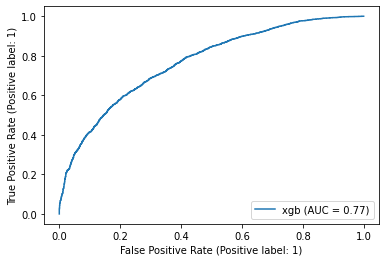

In [113]:
calc_scores(xgb_cv.best_estimator_, X_test, y_test, 'xgb')